# Exercise - NumPy Linear Algebra - SVD Reconstruction - SOLUTION

A very common usage of NumPy is to perform common linear algebra algorithms.  These are usually implemented efficiently for the CPU using a library like OpenBLAS.  We will see in a later tutorial how to move these computations to the GPU.

In this tutorial, we're going to look at the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) of a matrix.  The matrix will represent a grayscale image, and we will see how the image can be approximated by the top N singular values and vectors.  This could be used as part of an image compression system, for example.

We will need OpenCV to read the image format, and matplotlib to display the image and our reconstruction of it.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

Next let's download an image of Bryce's dog:

In [ ]:
import urllib.request
urllib.request.urlretrieve(
  "https://drive.usercontent.google.com/download?id=1ClKrHt4-SIHaeBJdF0K3MG64jyVnt62L&export=download",
  "loonie.jpg")

('loonie.jpg', <http.client.HTTPMessage at 0x7ef8e7334c10>)

Next we read the image in grayscale mode:

In [ ]:
image = cv2.imread("loonie.jpg", cv2.IMREAD_GRAYSCALE)

print(f"nbytes: {image.nbytes}")
print(f"shape: {image.shape}")
print(image)

nbytes: 1920000
shape: (1600, 1200)
[[127 128 135 ...  74  70  70]
 [128 132 135 ...  78  69  72]
 [119 127 131 ...  84  75  71]
 ...
 [140 133 127 ... 126 139 123]
 [144 136 129 ... 130 124 115]
 [155 145 133 ... 124 114 117]]


Here we can see the image is 1600x1200 pixels, and each pixel is an unsigned 8-bit value (0-255).  Let's plot it with matplotlib to verify it looks correct:

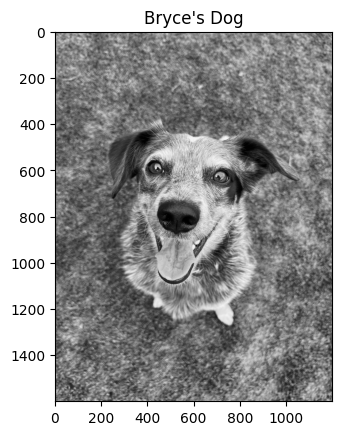

In [ ]:
plt.imshow(image, cmap="gray")
plt.title("Bryce's Dog")
plt.show()

Yes, we can confirm that is a dog (and a very cute one at that).  Now let's start doing some linear algebra!

NumPy provides an [implementation of SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).  By selecting `full_matrices=False`, we get the singular value matrix, `S`, as a 1D vector rather than a 2D diagonal matrix.

In [ ]:
U, S, Vt = np.linalg.svd(image, full_matrices=False)
U.shape, S.shape, Vt.shape

((1600, 1200), (1200,), (1200, 1200))

Since the image is not square and we've not selected `full_matrices`, NumPy returns `U` as a non-square matrix, `S` as the 1D vector which is the smaller of the two dimensions, and the `Vt` matrix is a square matrix.

The singular values are returned in descending order, which we can see if we look at the first 10 elements of `S`:

In [ ]:
S[:10]

array([168083.9407829 ,  23238.38484043,  19528.95172263,  15942.48480149,
        11745.41886782,  10402.5500467 ,   9557.42759704,   9301.19899873,
         8220.25409214,   8070.18502333])

In fact, if we look at the size of the singular values, we see that the first few contribute a lot to the matrix, and then fall off very rapidly:

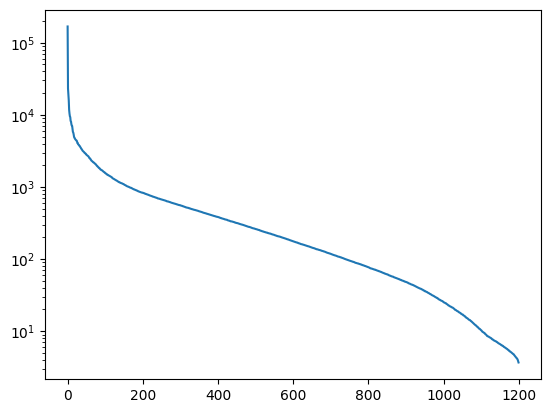

In [ ]:
plt.semilogy(S)

That suggests we can get a pretty good approximation of the original image with a relatively small number of terms.  We can reconstruct the image matrix by slicing the `U`, `S`, and `Vt` matrices and remultiplying them.  We will need to convert `S` back into a 2D matrix for the multiplication as well.  Note that we are using the `@` operator to perform matrix multiplication, because `*` does element-wise multiplication.

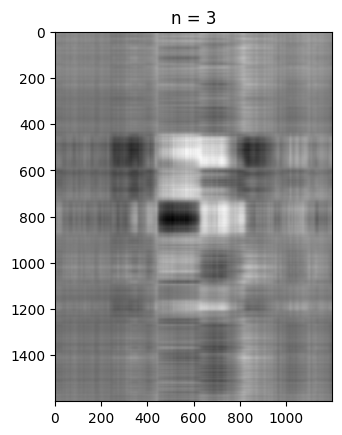

In [ ]:
# First 3 terms.
nterms = 3
reconstructed = U[:, :nterms] @ np.diag(S[:nterms]) @ Vt[:nterms, :]
plt.imshow(reconstructed, cmap="gray")
plt.title("n = 3")
plt.show()

That's still pretty fuzzy, so let's check out the image with more terms included:

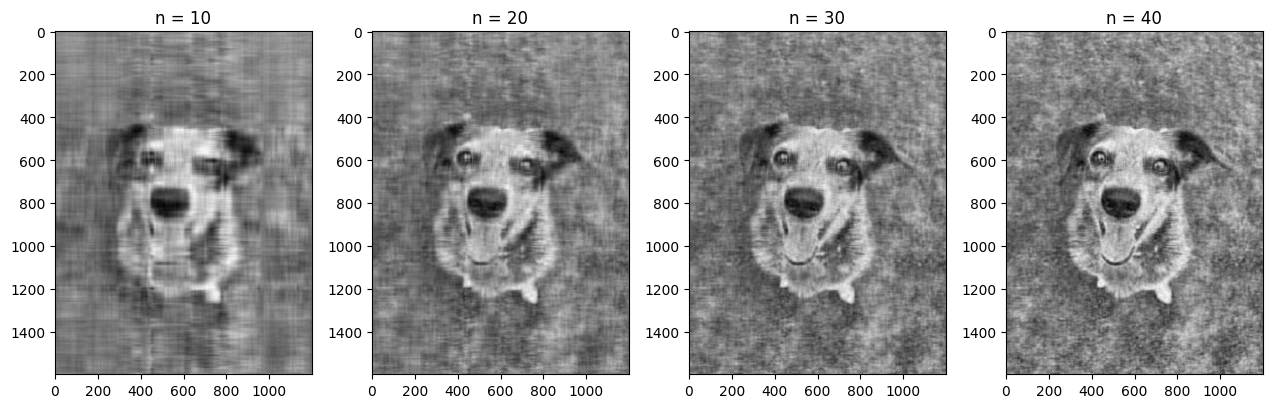

In [ ]:
plt.figure(figsize=(16, 4))

start, end, step = 10, 50, 10
for i in range(start, end, step):
  plt.subplot(1, (end - start) // step + 1, (i - start) // step + 1)
  reconstructed = U[:, :i] @ np.diag(S[:i]) @ Vt[:i, :]
  plt.imshow(reconstructed, cmap="gray")
  plt.title(f"n = {i}")

plt.tight_layout()
plt.show()

Now we'll print the compression ratio for the values of `n` used above.  This is the number of bytes of the reduced arrays added together and divided by the size of the original grayscale image array.  It seems we can get significant storage savings with this technique.

In [ ]:
for i in range(start, end, step):
  compress_ratio = (U[:, :i].nbytes + S[:i].nbytes + Vt[:i, :].nbytes) / image.nbytes
  print(f"n = {i}: compression = {compress_ratio:.1%}")

n = 10: compression = 11.7%
n = 20: compression = 23.3%
n = 30: compression = 35.0%
n = 40: compression = 46.7%


Next, we compute and display the difference in the reconstruction for `n = 10` and the original image using `cmap="coolwarm"` to display the difference.

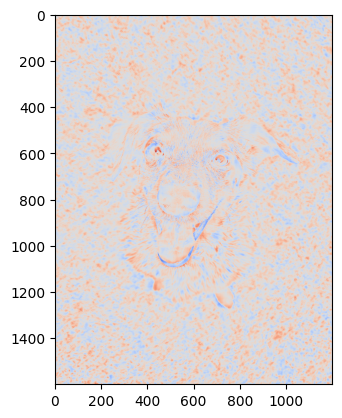

In [ ]:
delta = image - (U[:,:10] @ np.diag(S[:10]) @ Vt[:10,:])
plt.imshow(delta, cmap="coolwarm")